In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

hex_gi = pd.read_csv('../ComputedDataV5/ForModel/base_hex_grid_final.csv')
hex_gi = hex_gi[hex_gi['accident_count'] > 0]

In [14]:
hex_gi

,geometry,grid_id,road_len_bridleway,road_len_busway,road_len_cycleway,road_len_footway,road_len_living_street,road_len_motorway,road_len_motorway_link,road_len_path,...,count_bus_stop,count_train_station,count_mrt,count_youbike,count_parking_official,accident_count,gi_z,gi_p,gi_category,count_intersection
19,POLYGON ((235372.95266347632 2422243.039417010...,19,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,150.453856,...,0.0,0.0,0,0,0,1,-0.089314,0.001,Cold Spot (99%),0
71,POLYGON ((234772.95266347632 2422935.859740038...,71,0.0,0.0,0.0,132.594292,0.0,0.0,0.0,34.608004,...,0.0,0.0,0,0,0,3,0.149229,0.164,Not Significant,3
72,"POLYGON ((234922.95266347632 2422849.25719966,...",72,0.0,0.0,0.0,4.695836,0.0,0.0,0.0,0.000000,...,0.0,0.0,0,0,0,3,0.109472,0.202,Not Significant,6
87,POLYGON ((234772.95266347632 2423109.064820795...,87,0.0,0.0,0.0,33.443084,0.0,0.0,0.0,0.000000,...,2.0,0.0,0,1,0,1,0.228743,0.101,Not Significant,10
100,POLYGON ((234622.95266347632 2423195.667361174...,100,0.0,0.0,0.0,88.411304,0.0,0.0,0.0,0.000000,...,0.0,0.0,0,0,0,5,0.109472,0.371,Not Significant,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1406439,POLYGON ((307972.95266347635 2798790.884982549...,1406439,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,1.0,0.0,0,0,0,3,0.228743,0.104,Not Significant,3
1406441,POLYGON ((308272.95266347635 2798790.884982549...,1406441,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0,0,0,1,0.109472,0.118,Not Significant,1
1406442,POLYGON ((308422.95266347635 2798704.282442171...,1406442,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0,0,0,1,-0.049557,0.356,Not Significant,1
1406454,POLYGON ((307822.95266347635 2798877.487522928...,1406454,0.0,0.0,0.0,33.826691,0.0,0.0,0.0,0.000000,...,0.0,0.0,0,0,0,2,0.109472,0.138,Not Significant,2


In [ ]:
feature = 'count_crossing'
hex_grid_with_features_filter = hex_gi
np.log1p(hex_grid_with_features_filter[feature]).hist(bins=50, log=True)
# hex_grid_with_features_filter[feature].hist(bins=50, log=True)
plt.title(f'{feature}')
plt.show()

In [15]:
column_translation = {
    # --- 1. 來自 gis_osm_roads_free_1.shp (roads) ---
    'road_len_motorway': '國道(高速公路)長度(roads)',
    'road_len_motorway_link': '國道匝道長度(roads)',
    'road_len_trunk': '快速道路長度(roads)',
    'road_len_trunk_link': '快速道路匝道長度(roads)',
    'road_len_primary': '省道(主要幹道)長度(roads)',
    'road_len_primary_link': '省道匝道長度(roads)',
    'road_len_secondary': '縣道(次要幹道)長度(roads)',
    'road_len_secondary_link': '縣道匝道長度(roads)',
    'road_len_tertiary': '鄉道(一般道路)長度(roads)',
    'road_len_tertiary_link': '鄉道匝道長度(roads)',
    'road_len_unclassified': '無分級道路長度(roads)',
    'road_len_residential': '住宅區街道(巷弄)長度(roads)',
    'road_len_living_street': '人車共用道(生活街道)長度(roads)',
    'road_len_service': '服務道路長度(roads)',
    'road_len_pedestrian': '行人徒步區長度(roads)',
    'road_len_track': '產業道路長度(roads)',
    'road_len_busway': '公車專用道長度(roads)',
    'road_len_cycleway': '自行車道長度(roads)',
    'road_len_footway': '人行道長度(roads)',
    'road_len_path': '小徑長度(roads)',
    'road_len_steps': '階梯長度(roads)',
    'road_len_bridleway': '馬道長度(roads)',
    'road_len_unknown': '未知類型道路長度(roads)',
    
    # 產業道路細分 (roads)
    'road_len_track_grade1': '產業道路_硬鋪面(roads)',
    'road_len_track_grade2': '產業道路_混合鋪面(roads)',
    'road_len_track_grade3': '產業道路_軟混合(roads)',
    'road_len_track_grade4': '產業道路_植被壓實(roads)',
    'road_len_track_grade5': '產業道路_鬆軟泥土(roads)',

    # --- 2. 來自 gis_osm_traffic_free_1.shp (traffic) ---
    'count_traffic_signals': '交通號誌(紅綠燈)數量(traffic)',
    'count_stop': '停車標誌數量(traffic)',
    'count_crossing': '行人穿越道(斑馬線)數量(traffic)',
    'count_speed_camera': '測速照相機數量(traffic)',
    'count_parking': '路邊停車點數量(traffic)',
    'count_motorway_junction': '交流道數量(traffic)',

    # --- 3. 來自 gis_osm_transport_free_1.shp (transport) ---
    'count_bus_stop': '公車站牌數量(transport)',
    'count_train_station': '火車站數量(transport)',

    # --- 4. 來自 gis_osm_pois_free_1.shp (pois) ---
    # 'count_alcohol': '飲酒場所數量(pois)',
    # 'count_convenience': '便利商店數量(pois)',
    # 'count_school': '學校數量(pois)',

    # --- 5. 來自 外部 CSV 資料 (local data) ---
    'count_mrt': '捷運站出口數量(mrt)',
    'count_youbike': 'YouBike站點數量(youbike)',
    'count_parking_official': '公有路外停車場數量(parkinglot)',

    'count_intersection': '交叉口數量(roads)',

    # --- 6. 模型結果 ---
    'gi_category': 'gi_category'
}
hex_gi = hex_gi[column_translation]

/var/folders/w2/_g9w5yys0f171q4qqm469z1h0000gn/T/ipykernel_63669/1454873022.py:61: FutureWarning: Passing a dict as an indexer is deprecated and will raise in a future version. Use a list instead.
  hex_gi = hex_gi[column_translation]


In [16]:
from new_model import model_preprocess

X_train_bal, X_test_original, y_train_bal, y_test_original, X_test_rus, y_test_rus, feat_names = model_preprocess(
    hex_gi, dim='1way'
)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_bal, y_train_bal)
y_pred_rf = rf_model.predict(X_test_original)

print(classification_report(y_test_original, y_pred_rf))

# y_pred_rf_rus = rf_model.predict(X_test_rus)
# print(classification_report(y_test_rus, y_pred_rf_rus))

/Users/wangqiqian/opt/anaconda3/envs/ST-RTA/lib/python3.9/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/wangqiqian/opt/anaconda3/envs/ST-RTA/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/Users/wangqiqian/opt/anaconda3/envs/ST-RTA/lib/python3.9/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/wangqiqian/opt/anaconda3/envs/ST-RTA/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Us

原始訓練集分佈: [36802 48546]
降採樣後訓練集: [36802 36802]
              precision    recall  f1-score   support

           0       0.65      0.73      0.69      9201
           1       0.77      0.70      0.74     12137

    accuracy                           0.72     21338
   macro avg       0.71      0.72      0.71     21338
weighted avg       0.72      0.72      0.72     21338



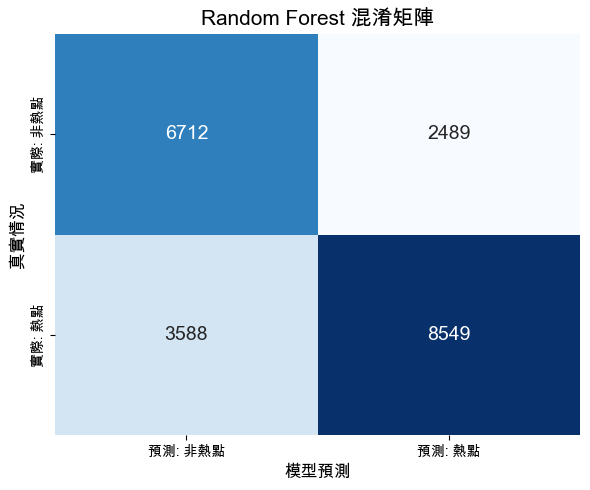

/var/folders/w2/_g9w5yys0f171q4qqm469z1h0000gn/T/ipykernel_63669/2611011706.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature_TW', data=feature_df, palette='Reds_r')


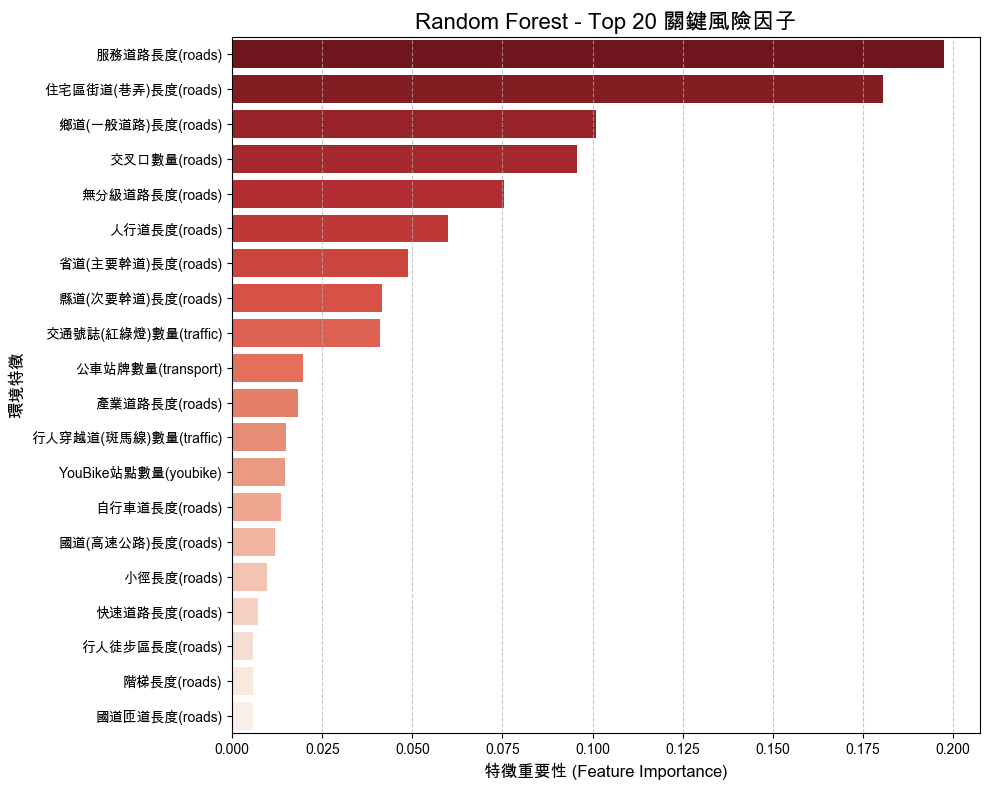

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix

import platform
system = platform.system()
if system == 'Darwin':
    plt.rcParams['font.family'] = ['Arial Unicode MS']
elif system == 'Windows':
    plt.rcParams['font.family'] = ['Microsoft JhengHei']

def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['預測: 非熱點', '預測: 熱點'],
                yticklabels=['實際: 非熱點', '實際: 熱點'],
                annot_kws={"size": 14})
    plt.title('Random Forest 混淆矩陣', fontsize=15)
    plt.ylabel('真實情況', fontsize=12)
    plt.xlabel('模型預測', fontsize=12)
    plt.tight_layout()
    plt.show()

def plot_feature_importance(model, feature_names, top_n=20):

    importances = model.feature_importances_
    feature_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    })

    feature_df['Feature_TW'] = feature_df['Feature'].map(column_translation)
    feature_df['Feature_TW'] = feature_df['Feature_TW'].fillna(feature_df['Feature'])
    feature_df = feature_df.sort_values(by='Importance', ascending=False).head(top_n)

    plt.figure(figsize=(10, 8))
    sns.barplot(x='Importance', y='Feature_TW', data=feature_df, palette='Reds_r')
    
    plt.title(f'Random Forest - Top {top_n} 關鍵風險因子', fontsize=16, fontweight='bold')
    plt.xlabel('特徵重要性 (Feature Importance)', fontsize=12)
    plt.ylabel('環境特徵', fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(y_test_original, y_pred_rf)
plot_feature_importance(rf_model, feat_names, top_n=20)